# Estimating recharge
*R.A. Collenteur, University of Graz*

In this example notebook it is shown how to obtain groundwater recharge estimates using linear and non-linear TFN models available in Pastas. To illustrate the methods we look at example models for a groundwater level time series observed near the town of Wagna in Southeastern Austria. This analysis is based on the study from [Collenteur et al. (2021)](#References).

<div class="alert alert-warning">
<b>Note:</b>
While the groundwater level data is the same to that used for the publication, the precipitation and potential evaporation data is not the same (due to open data issues). The results from this notebook are therefore not the same as in the manuscript. 
</div>

In [1]:
%load_ext lab_black

In [2]:
import pandas as pd
import pastas as ps
import matplotlib.pyplot as plt

ps.set_log_level("ERROR")
ps.show_versions()

Python version: 3.9.6 (default, Nov  3 2021, 12:35:15) 
[GCC 9.3.0]
Numpy version: 1.20.1
Scipy version: 1.7.1
Pandas version: 1.2.4
Pastas version: 0.18.0
Matplotlib version: 3.4.2


## 1. Load and visualize the input data
Below we load and visualize the data used in this example. This is the input data necessary to for the estimation of groundwater recharge: precipitation, potential evaporation, and groundwater levels. The precipitation and evaporation should be available at daily time intervals and provided in mm/day.

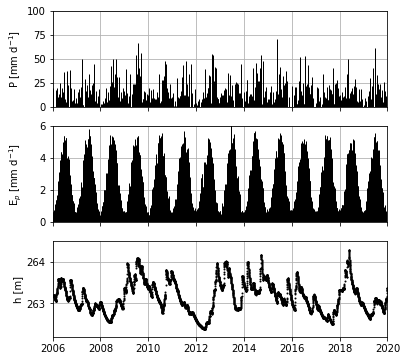

In [3]:
head = pd.read_csv(
    "data_wagna/head_wagna.csv", index_col=0, parse_dates=True, squeeze=True, skiprows=2
).loc["2006":]
evap = pd.read_csv(
    "data_wagna/evap_wagna.csv", index_col=0, parse_dates=True, squeeze=True, skiprows=2
)
rain = pd.read_csv(
    "data_wagna/rain_wagna.csv", index_col=0, parse_dates=True, squeeze=True, skiprows=2
)

### Create a plot of all the input data
fig, [ax1, ax2, ax3] = plt.subplots(3, 1, sharex=True, figsize=(6, 6))

ax1.vlines(rain.index, [0], rain.values, color="k", lw=1)
ax1.set_ylabel("P [mm d$^{-1}$]")
ax1.set_ylim(0, 100)
ax2.vlines(evap.index, [0], evap.values, color="k", lw=1)
ax2.set_ylabel("E$_p$ [mm d$^{-1}$]\n")
ax2.set_ylim(0, 6)
ax3.plot(head, marker=".", markersize=2, color="k", linestyle=" ")
ax3.set_ylabel("h [m]")
ax3.set_ylim(262.2, 264.5)
for ax in [ax1, ax2, ax3]:
    ax.grid()

plt.xlim(pd.Timestamp("2006-01-01"), pd.Timestamp("2020-01-01"))

## 2. Creating and calibrating Pastas models
The next step is the create the TFN models in Pastas and calibrate them. Here we create two types of TFN models: one with a linear approximation for the recharge and one with a non-linear recharge model. Based on the time step analysis we calibrate the models on groundwater level time series with a 10-day time interval between observations. 

It is important to use the correct settings for the model calibration In particular it is important to use a warmup period for the non-linear model, where both precipitation and evaporation is available. Here we use a 10-year period for calibration and a three year period for validation.

In [4]:
# Model settings
tmin = pd.Timestamp("2007-01-01") # Needs warmup
tmax = pd.Timestamp("2016-12-31")
tmax_val= pd.Timestamp("2020-01-01")
noise = True
solver = ps.LmfitSolve
dt = 10
freq = "10D"
h = head.iloc[0::dt]

mls = {
    "Linear": [ps.FourParam, ps.rch.Linear()],
    "Non-linear": [ps.Exponential, ps.rch.FlexModel()],
}

for name, [rfunc, rch] in mls.items():
    # Create a Pastas model and add the recharge model
    ml = ps.Model(h, name=name)
    sm = ps.RechargeModel(rain, evap, recharge=rch, rfunc=rfunc, name="rch")
    ml.add_stressmodel(sm)

    # In case of the non-linear model, change some parameter settings
    if name == "Non-linear":
        ml.set_parameter("rch_srmax", vary=False)
        ml.set_parameter("rch_kv", vary=True)
        ml.set_parameter("rch_lp", vary=False, initial=0.25)
        ml.set_parameter("constant_d", vary=True, initial=262, pmax=head.min())

    # Add the ARMA(1,1) noise model and solve the Pastas model
    ml.add_noisemodel(ps.ArmaModel())
    ml.solve(tmin=tmin, tmax=tmax, noise=True, solver=solver, method="least_squares", report="basic")
    mls[name] = ml

ImportError: lmfit not installed. Please install lmfit first.

## 3. Check for autocorrelation
After the models are calibrated, the noise time series may be checked for autocorrelation. This is especially important here because in the next step we use the estimated standard errors of the parameters to compute the 95% confidence intervals of the recharge estimates. The plots below show that there is no significant autocorrelation (with $\alpha$=0.05).

In [ ]:
fig, axes = plt.subplots(2, 1, figsize=(6,5), sharex=True, sharey=True)

for i, ml in enumerate(mls.values()):
    noise = ml.noise().asfreq(freq).fillna(0.0)  # Fill up two nan-values so it is regular
    ps.stats.plot_acf(noise, acf_options=dict(bin_method="regular"), alpha=0.05, ax=axes[i])
    axes[i].set_title(ml.name)
    axes[i].set_ylim(-0.2, 0.2)
    axes[i].set_ylabel("ACF [-]")
    axes[i].set_xlabel("")

plt.xlim(10)
plt.xlabel("Time lag [days]")
plt.tight_layout()

## 4. Compute confidence intervals
In the following code-block the 95% confidence intervals of the recharge estimates are computed using an monte carlo analysis. This may take a bit of time, depending on the number of monte carlo runs are performed (first line).

In [ ]:
n = int(1e4)  # number of monte carlo runs
alpha = 0.05  # 95% confidence interval
q = [alpha / 2, 1 - alpha / 2]

# Store the Upper and Lower boundaries of the 95% interval
yerru = []  
yerrl = []
yerru_A = []
yerrl_A = []

# Recharge data
data_r = pd.DataFrame({"Linear": mls["Linear"].get_stress("rch"),
                       "Non-linear": mls["Non-linear"].get_stress("rch")})

for ml in mls.values():
    func = ml.stressmodels["rch"].get_stress
    params = ml.fit.get_parameter_sample(n=n, name="rch")
    data = {}

    # Here we run the model n times with different parameter samples
    for i, param in enumerate(params):
        data[i] = func(p=param)

    df = pd.DataFrame.from_dict(data, orient="columns").loc[tmin:tmax_val]
    
    # store recharge estimates at 10-day intervals
    df = df.resample(freq).sum()
    yerrl.append(df.quantile(q=q, axis=1).transpose().iloc[:,0])
    yerru.append(df.quantile(q=q, axis=1).transpose().iloc[:,1])

    # store recharge estimates at one year sums
    df = df.resample("A").sum()
    rch = data_r[ml.name].resample("A").sum()
    yerrl_A.append(df.quantile(q=q, axis=1).transpose().subtract(rch, axis=0).iloc[:,0].dropna())
    yerru_A.append(df.quantile(q=q, axis=1).transpose().subtract(rch, axis=0).iloc[:,1].dropna())

## 5. Visualize the results
We can now plot the simulated groundwater levels and the estimated groundwater recharge for both models. For the recharge estimates, here the sums over 10-day intervals, we also plot the 95% confidence intervals. 

In [ ]:
plt.figure(figsize=(12, 10))
ax = plt.subplot2grid((4,1), (0,0), rowspan=2)

head.plot(ax=ax, linestyle=" ", c="gray", marker=".", x_compat=True, label="observed")
ml.oseries.series.plot(ax=ax, marker=".", c="k", linestyle=" ", label="calibration")

# Create the arrows indicating the calibration and validation period
kwargs = dict(textcoords='offset points', arrowprops=dict(arrowstyle="->"), 
              va="center", ha="center", xycoords='data',)
ax.annotate("calibration period", xy=("2007-01-01", 262.25), xytext=(270, 0), **kwargs)
ax.annotate("", xy=("2017-01-01", 262.25), xytext=(-200, 0), **kwargs)
ax.annotate("validation", xy=("2017-01-01", 262.25), xytext=(80, 0), **kwargs)
ax.annotate("", xy=("2020-01-01", 262.25), xytext=(-50, 0), **kwargs)

# Plot the recharge fluxes
for i, ml in enumerate(mls.values()):
    axn = plt.subplot2grid((4,1), (i+2,0), sharex=ax)
    axn.grid(True, zorder=-10)
    axn.set_axisbelow(True)

    ml.simulate(tmax=tmax_val).plot(ax=ax, label=ml.name, x_compat=True)
    rch = ml.get_stress("rch", tmin=tmin, tmax=tmax_val).resample(freq).sum()
    
    axn.fill_between(yerrl[i].index, yerrl[i].values, yerru[i].values, 
                     step="pre", edgecolor="C0", zorder=0, facecolor="C0")
    axn.plot(rch.index, rch.values, c="k", drawstyle='steps', label=ml.name, lw=1)

    axn.set_yticks([-50, 0, 50, 100, 150])

    axn.set_ylabel("R [mm 10 d$^{-1}$]")
    axn.legend(loc=2, ncol=2)
    axn.axvline(tmax, c="k", linestyle="--")
    axn.set_xticks([])
    
ax.legend(ncol=5, loc=2, bbox_to_anchor=(0.01, 1.15), framealpha=1, fancybox=False)
ax.axvline(tmax, c="k", linestyle="--")
ax.set_ylabel("Groundwater level [m]")
ax.set_yticks([262.5, 263.0, 263.5, 264.0])
ax.grid()
axn.set_xlim([tmin, tmax_val])
axn.set_xlabel("Date")
axn.set_xticks([pd.to_datetime(str(year)) for year in range(2007, 2021, 2)]);

## 6. Plot the annual recharge rates
We may also be interested in the estimated annual recharge rates. These can easily be computed busing the resample method from Pandas. We also show the 95% confidence interval for the estimated annual recharge rates.

In [ ]:
rch = data_r.loc[tmin:"2019"].resample("A").sum()
yerr = [[-l, u] for l, u in zip(yerrl_A, yerru_A)]
ax = rch.plot.bar(figsize=(12,2), width=0.91, yerr=yerr)
ax.set_xticklabels(labels=rch.index.year, rotation=0, ha='center')
ax.set_ylabel("Recharge [mm a$^{-1}$]")
ax.legend(ncol=3);

## 7. Plot the step and block response functions
We can also plot the calibrated impulse response functions.

In [ ]:
fig, [ax, ax1] = plt.subplots(1,2, figsize=(5, 2.5), sharex=True)

for ml in mls.values():
    ml.get_block_response("rch").plot(ax=ax)
    ml.get_step_response("rch").plot(ax=ax1)

ax.set_ylabel("Block Response [m]")
ax.legend(mls.keys())

ax1.set_ylabel("Step Response [m]")
ax1.set_xlim(0, 700)

plt.tight_layout()

## 8. Compute the goodness-of-fit for groundwater level simulation
The following code-block shows how a summary table of the goodness-of-fit with different metrics can be made. Here we show the goodness-of-fit metrics for the groundwater level simulation. 

In [ ]:
# Make a table of the head performance
periods = ["Cal.", "Val."]
mi = pd.MultiIndex.from_product([mls.keys(), periods])
idx = ["mae", "rmse", "nse", 'kge_2012']
index = ["MAE [m]", "RMSE [m]", "NSE [-]", "KGE [-]"]

metrics = pd.DataFrame(index=idx, columns=mi)
for name, ml in mls.items():
    metrics.loc[metrics.index, (name, periods[0])] = ml.stats.summary(stats=metrics.index, tmin=tmin, tmax=tmax).to_numpy().reshape(4)
    metrics.loc[metrics.index, (name, periods[1])] = ml.stats.summary(stats=metrics.index, tmin=tmax, tmax=tmax_val).to_numpy().reshape(4)
    
metrics.index = index
metrics.astype(float).round(2)

## Data sources:
- The groundwater level time series for the hydrological research station Wagna in Austria were obtained from the government of Styria in cooperation with [JR-AquaConsol](https://www.jr-aquaconsol.at/). We acknowledge JR-AquaConsol for providing the time series and allowing its use in this example. This data may not be redistributed without explicit permission from JR-AquaConsol.

- Precipitation and evaporation time series were obtained from the gridded E-OBS database [(Cornes et al. (2018)](#References). We acknowledge the E-OBS dataset from the EU-FP6 project UERRA (https://www.uerra.eu) and the Copernicus Climate Change Service, and the data providers in the ECA&D project (https://www.ecad.eu). 

## References

- Cornes, R., G. van der Schrier, E.J.M. van den Besselaar, and P.D. Jones. 2018: An Ensemble Version of the E-OBS Temperature and Precipitation Datasets, J. Geophys. Res. Atmos., 123. doi:10.1029/2017JD028200.
- Collenteur, R., Bakker, M., Klammler, G., and Birk, S. (2021) [Estimation of groundwater recharge from groundwater levels using nonlinear transfer function noise models and comparison to lysimeter data](https://doi.org/10.5194/hess-2020-392), Hydrol. Earth Syst. Sci., 25, 2931–2949.